# Unsupervised GraphSAGE 
## node classification
### demonstrated on the Cora citation dataset

In this example, we build  the unsupervised GraphSAGE model with (target, context) sampling based on random walks on the graph for training the model. In this extension of unsupervised GraphSAGE, the sampling of positive and negative (target, context) pairs is an implementation of the procedure outlined in the [Inductive Representation Learning on Large Graphs](https://arxiv.org/pdf/1706.02216.pdf) paper. The original implemention of the GraphSAGE model can be found here [GraphSAGE](http://snap.stanford.edu/graphsage/). 

The Cora dataset is used to test the process of unsupervised learning with GraphgSAGE. 

### Unsupervised GraphSAGE:

A high-level explanation of the unsupervised GraphSAGE method is as follows.

First the GraphSAGE model is trained by feeding it a training set of postive links (target, context) pairs and equal number of negative (target, context) pairs. Incase of unsupervised training, positive links are the (target, context) pair that co-occur near each other on fixed-length random walks. Equal number of negative links for each target node (contexts that do not co-occur on random walks with the target) are sampled based on the degree distribution of the graph. 

The model first generates the embeddings for the each target and each context. 
These embeddings are then fed into a link classification layer, which first applies a binary operator to those node embeddings (e.g., concatenating them) to construct the embedding of the potential link. 

The obtained link embeddings are passed through the dense link classification layer to obtain link predictions - probability for these candidate links to actually exist in the network. 
The entire model is trained end-to-end by minimizing the loss function of choice (e.g., binary cross-entropy between predicted link probabilities and true link labels, with true/false citation links having labels 1/0) using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' links fed into the model.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler


import keras 
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar

Using TensorFlow backend.


### Loading the CORA network data

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [2]:
data_dir = "~/data/cora"

Load the graph from edgelist

In [3]:
edgelist = pd.read_table(os.path.join(data_dir, "cora.cites"), header=None, names=["source", "target"])
edgelist["label"] = "cites"  # set the edge type

In [4]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

Specify the node types

In [5]:
nx.set_node_attributes(Gnx, "paper", "label")

Load the features and subject for the nodes

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_table(os.path.join(data_dir, "cora.content"), header=None, names=column_names)

The node features are all attributes except the paper subject (we will use this for plotting the embeddings later)

In [7]:
node_features = node_data[feature_names]

In [12]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



### Sampling random walks on the graph
From the original graph G, build a training set of (target, context) pairs by randomly sampling node pairs from fixed length random walks. We also sample an equal number of negative pairs that using the same target nodes and a context node sampled randomly from a scaled degree distribution of the graph.

#### Random walks: 
First a predefined number of random walks is generated starting from each node in the graph. 
The postive and negative target-context pairs are then extracted from these walks.

We perform biased random walks here just as a one of the many ways random walks can be done over a graph. These walks can be replaced by any other random walk routine. 

The biased random walks are the same as that used be `node2vec` and have two parameters $p$ and $q$ that specify the bias of the walk.

In [8]:
G = sg.StellarGraph(Gnx, node_features=node_features)
rw = UniformRandomWalk(G)

Specify the parameters: the number of walks to take per node, the length of each walk, and the window size.

In [9]:
number_of_walks = 1
length = 5

Generate all the biased random walks.

In [11]:
unsupervisedSamples = UnsupervisedSampler(G, nodes = G.nodes(),  walker = rw, length = length, number_of_walks = number_of_walks )

The graph G together with the unsupervised sampler will be used to generate samples.

Next, we create the link mappers for sampling and streaming training and testing data to the model. The link mappers essentially "map" pairs of nodes `(paper1, paper2)` to the input of GraphSAGE: they take minibatches of node pairs, sample 2-hop subgraphs with `(paper1, paper2)` head nodes extracted from those pairs, and feed them, together with the corresponding binary labels indicating whether those pairs represent true or false citation links, to the input layer of the GraphSAGE model, for SGD updates of the model parameters.

Specify:
1. The minibatch size (number of node pairs per minibatch).
2. The number of epochs for training the model.
3. The sizes of 1- and 2-hop neighbour samples for GraphSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model. In this example, we are defining a 2-layer GraphSAGE model.

In [13]:
batch_size = 50
epochs = 5
num_samples = [10, 5]

In [15]:
train_gen = GraphSAGELinkGenerator(G, batch_size, num_samples).flow(unsupervisedSamples)

Running GraphSAGELinkGenerator with an estimated 271 batches generated on the fly per epoch.


Build the model: a 2-layer GraphSAGE model acting as node representation learner, with a link classification layer on concatenated `(paper1, paper2)` node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 50 for both GraphSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive dropout rate, 0 < dropout < 1)
Note that the length of layer_sizes list must be equal to the length of num_samples, as len(num_samples) defines the number of hops (layers) in the GraphSAGE model.

In [16]:
layer_sizes = [50, 50]
assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(
        layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.0, normalize="l2"
    )

In [17]:
# Expose input and output sockets of graphsage, for source and destination nodes:
x_inp_src, x_out_src = graphsage.default_model(flatten_output=False)
x_inp_dst, x_out_dst = graphsage.default_model(flatten_output=False)
# re-pack into a list where (source, destination) inputs alternate, for link inputs:
x_inp = [x for ab in zip(x_inp_src, x_inp_dst) for x in ab]
# same for outputs:
x_out = [x_out_src, x_out_dst]

Final link classification layer that takes a pair of node embeddings produced by graphsage, applies a binary operator to them to produce the corresponding link embedding ('ip' for inner product; other options for the binary operator can be seen by running a cell with `?link_classification` in it), and passes it through a dense layer:

In [18]:
prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method='ip'
    )(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the GraphSAGE and prediction layers into a Keras model, and specify the loss

In [19]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

Train the model. Note that using multiprocessing slows down the sampling. Using multiple workers, however, speeds it up considerably.

In [20]:
history = model.fit_generator(
        train_gen,
        epochs=epochs,
        verbose=1,
        use_multiprocessing=False,
        workers=4,
        shuffle=True,
    )

Epoch 1/5
271/271 [==============================] - 13s 46ms/step - loss: 0.5943 - binary_accuracy: 0.7123
Epoch 2/5
271/271 [==============================] - 12s 45ms/step - loss: 0.5536 - binary_accuracy: 0.7615
Epoch 3/5
271/271 [==============================] - 12s 45ms/step - loss: 0.5443 - binary_accuracy: 0.7712
Epoch 4/5
271/271 [==============================] - 12s 45ms/step - loss: 0.5454 - binary_accuracy: 0.7681
Epoch 5/5
271/271 [==============================] - 12s 46ms/step - loss: 0.5397 - binary_accuracy: 0.7820


Plot the training history:

Evaluate the trained model on test citation links:

In [21]:
test_gen = GraphSAGELinkGenerator(G,  batch_size, num_samples).flow(edge_ids_test, edge_labels_test)
train_metrics = model.evaluate_generator(train_gen, workers=4, verbose=1)
test_metrics = model.evaluate_generator(test_gen, workers=4, verbose=1)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

NameError: name 'edge_ids_test' is not defined

### Extracting node embeddings

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

We use another Keras model to extract the embeddings for all the nodes.

In [23]:
node_ids = list(G.nodes())

**Using the original node pair model**

The current inputs and outputs require two nodes. We should fix this by creating a new sinlge node GraphSAGE model that has the same structure and weights as the trained link model.

In [24]:
embedding_model = keras.Model(inputs=x_inp, outputs=x_out)
all_nodes_links = [ [n,n] for n in  node_ids]
all_mapper = GraphSAGELinkGenerator(G, batch_size, num_samples).flow(all_nodes_links)
emb = embedding_model.predict_generator(all_mapper, workers=4, verbose=1)

55/55 [==============================] - 2s 34ms/step


Reshape node embeddings to remove second (neighbour) dimension

In [25]:
node_embeddings = emb[0][:,0,:]

Plot the embeddings

In [26]:
node_subject = node_data["subject"].astype('category').cat.codes
X = node_embeddings
if X.shape[1] > 2:
    transform = TSNE #PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_data.index)
    emb_transformed['label'] = [node_subject[n] for n in G.nodes()]
else:
    emb_transformed = pd.DataFrame(X, index=node_data.index)
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] =  [node_subject[n] for n in G.nodes()]

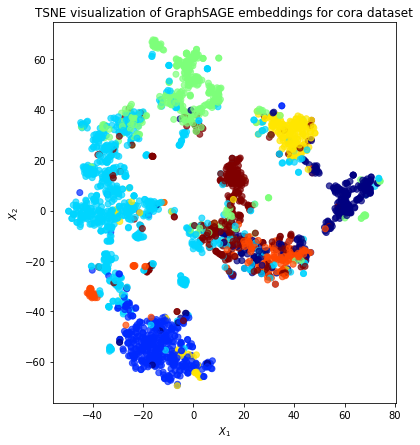

In [27]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GraphSAGE embeddings for cora dataset'.format(transform.__name__))
plt.show()

**Building a new node-based model**

A node-based embedding model made by creating another graphsage model with the same parameters and settng the weights of the trained model.

In [28]:
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples).flow(node_ids)

In [29]:
graphsage = GraphSAGE(
        layer_sizes=layer_sizes, generator=node_gen, bias=True, dropout=0.0, normalize="l2"
    )
x_inp_emb, x_out_emb = graphsage.default_model(flatten_output=False)
embedding_model = keras.Model(inputs=x_inp_emb, outputs=x_out_emb)

In [30]:
embedding_model.set_weights(model.get_weights())

We now get a new Node Generator and feed all nodes into it.

In [31]:
emb = embedding_model.predict_generator(node_gen, workers=4, verbose=1)
node_embeddings = emb[:,0,:]

55/55 [==============================] - 1s 21ms/step


In [32]:
node_subject = node_data["subject"].astype('category').cat.codes

X = node_embeddings
if X.shape[1] > 2:
    transform = TSNE #PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
    emb_transformed['label'] = node_subject
else:
    emb_transformed = pd.DataFrame(X, index=node_ids)
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] =  node_subject

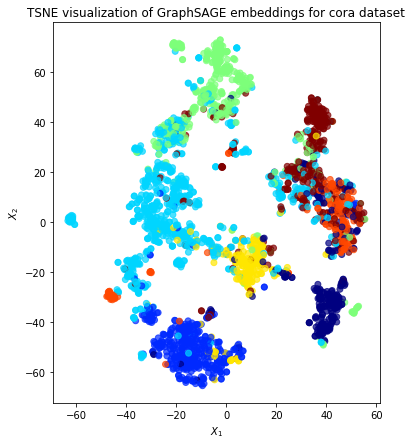

In [33]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GraphSAGE embeddings for cora dataset'.format(transform.__name__))
plt.show()